In [1]:
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from tensorflow import keras
from livelossplot.inputs.keras import PlotLossesCallback
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle

In [2]:
batch_size = 2
train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, 
                                                       zoom_range=0.2, 
                                                       horizontal_flip=True,
                                                       fill_mode="nearest",
                                                       rotation_range=25,
                                                       preprocessing_function=preprocess_input)

#train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, rotation_range=90, 
#                                                     width_shift_range=0.5, 
#                                                     height_shift_range=0.5,
#                                                     zoom_range=0.2,
 #                                                    horizontal_flip=True, 
#                                                     vertical_flip=True,
#                                                     preprocessing_function=preprocess_input)


test= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
traingen = train.flow_from_directory(directory="train",
                                        target_size=(224,224), 
                                        class_mode='categorical',
                                        shuffle= True,
                                        )

Found 6005 images belonging to 102 classes.


In [4]:
validgen = test.flow_from_directory(directory="val", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    shuffle= True,
                                    )

Found 1019 images belonging to 102 classes.


In [5]:
pic = load_img("image_00070.jpg")
pic_array = img_to_array(pic)
pic_array = pic_array.reshape((1, )+ pic_array.shape)
pic_array.shape

(1, 500, 667, 3)

count = 0
for batch in train.flow(pic_array, batch_size = 1, save_to_dir = "image_traingen", save_prefix= 'flower', save_format='jpeg'):
    count +=1
    if count >35:
        break

In [6]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    print("optimizer: ", optimizer)
    vgg_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape = (224,224,3))
    
    if fine_tune > 0:
        for layer in vgg_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in vgg_model.layers:
            layer.trainable = False
            
            
    top_model = vgg_model.output
    #top_model = Dropout(0.5)(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    #-------------------------------------------------#
    model = Model(inputs=vgg_model.input, outputs=output_layer)
    #model.layers[22].trainable = False
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(lr=0.0001, decay=0.0001/100)
n_classes=102

n_steps = len(traingen)//batch_size
n_val_steps = len(validgen)//batch_size
n_epochs = 50

# First we'll train the model without Fine-tuning
InceptionV3_model = create_model(input_shape, n_classes, optim_1, fine_tune=4)

optimizer:  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001AE10BE3A60>


In [ ]:

InceptionV3_model.summary()

In [10]:
for i,layer in enumerate(InceptionV3_model.layers):
    print(i,layer.name," : " ,layer.trainable)

0 input_1  :  False
1 conv2d  :  False
2 batch_normalization  :  False
3 activation  :  False
4 conv2d_1  :  False
5 batch_normalization_1  :  False
6 activation_1  :  False
7 conv2d_2  :  False
8 batch_normalization_2  :  False
9 activation_2  :  False
10 max_pooling2d  :  False
11 conv2d_3  :  False
12 batch_normalization_3  :  False
13 activation_3  :  False
14 conv2d_4  :  False
15 batch_normalization_4  :  False
16 activation_4  :  False
17 max_pooling2d_1  :  False
18 conv2d_8  :  False
19 batch_normalization_8  :  False
20 activation_8  :  False
21 conv2d_6  :  False
22 conv2d_9  :  False
23 batch_normalization_6  :  False
24 batch_normalization_9  :  False
25 activation_6  :  False
26 activation_9  :  False
27 average_pooling2d  :  False
28 conv2d_5  :  False
29 conv2d_7  :  False
30 conv2d_10  :  False
31 conv2d_11  :  False
32 batch_normalization_5  :  False
33 batch_normalization_7  :  False
34 batch_normalization_10  :  False
35 batch_normalization_11  :  False
36 activatio

In [11]:


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='inceptionv3.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

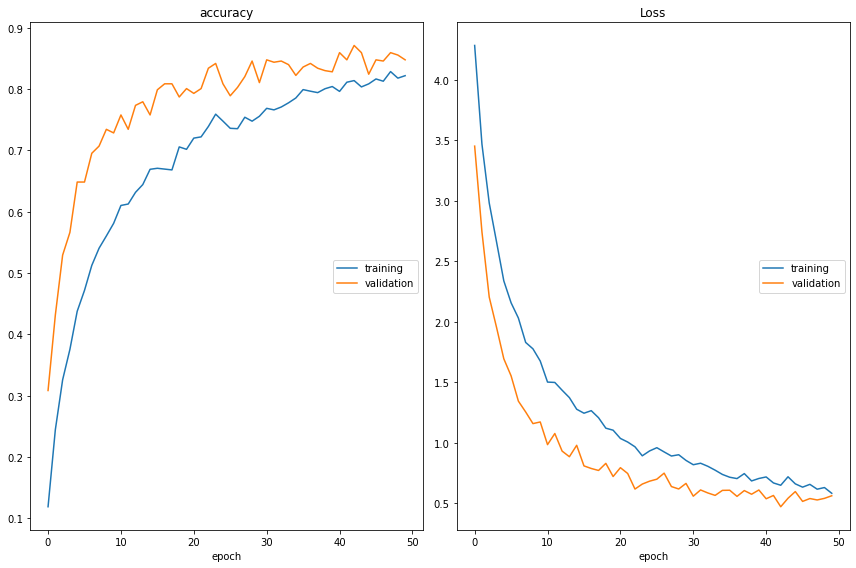

accuracy
	training         	 (min:    0.119, max:    0.828, cur:    0.822)
	validation       	 (min:    0.309, max:    0.871, cur:    0.848)
Loss
	training         	 (min:    0.584, max:    4.284, cur:    0.584)
	validation       	 (min:    0.473, max:    3.452, cur:    0.563)
94/94 [==============================] - 44s 471ms/step - loss: 0.5837 - accuracy: 0.8218 - val_loss: 0.5633 - val_accuracy: 0.8477


In [11]:
#InceptionV3_model.load_weights('4096-512.hdf5')
vgg_history = InceptionV3_model.fit(traingen,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            )

In [12]:
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']

loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

In [13]:
np.mean(val_acc[-40:])

0.82099609375

In [14]:
np.mean(acc[-30:])

0.7803523043791453

In [12]:
testgen = test.flow_from_directory(directory="test", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    )

Found 1165 images belonging to 102 classes.


In [20]:
#InceptionV3_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights
InceptionV3_model.load_weights('inceptionv3.hdf5')

In [21]:
results = InceptionV3_model.evaluate(testgen)

37/37 [==============================] - 6s 161ms/step - loss: 0.5623 - accuracy: 0.8627


# predict

In [22]:
dataset_test ="test"
test_dir = Path(dataset_test)
test_data_image = list(test_dir.glob('*/*.jpg'))

In [23]:
a_file = open("data_array.pkl", "rb")
class_names = pickle.load(a_file)

In [24]:
a_file1 = open("data.pkl", "rb")
flower_dict = pickle.load(a_file1)

In [34]:

for img_path in test_data_image:
    img = keras.preprocessing.image.load_img( img_path, target_size=(224,224) )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = InceptionV3_model.predict(img_array)
    #print("------prediction-------")
    #print(prediction)
    #print("------prediction[0]-------")
    score = tf.nn.softmax(prediction[0])
    print(score)
    #print("------------score---------")
    index = class_names[np.argmax(score)]
    int_index = int(index)
    #print(img_path, ' : ', class_names[np.argmax(score)] ,' : ',flower_dict[int_index])
    #print(class_names[np.argmax(score)], " with ", 100 * np.max(score))

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620832 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.01275673 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967505 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309 0.00967309
 0.00967309 0.00967309 0.00967309 0.00967309 0.0096

tf.Tensor(
[0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964601 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00985368 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486 0.00964486
 0.00964486 0.00964486 0.00964486 0.00964486 0.0096

tf.Tensor(
[0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964211 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00967777 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.02611322 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209 0.00964209
 0.00964209 0.00964209 0.00964209 0.00964209 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620832 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964157 0.02619695 0.00964157 0.00964157 0.00964157 0.00964195
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964165 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964161 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.0096416  0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964269 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964419 0.00964157 0.00964157 0.00964157
 0.00964157 0.00964157 0.00964157 0.00964157 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.00964162 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.00964158 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620781 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620832 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620832 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.02383448 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965555 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00997276 0.00965554 0.00965554 0.00965554
 0.00965554 0.00965554 0.00965554 0.00965554 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.00964151 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620829 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965658 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.01057141 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.02396327 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463 0.00965463
 0.00965463 0.00965463 0.00965463 0.00965463 0.0096

tf.Tensor(
[0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967474 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967507 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.01308952 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.01943715 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473 0.00967473
 0.00967473 0.00967473 0.00967473 0.00967473 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620832 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620832 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.02620718 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964185 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964159 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.0096

tf.Tensor(
[0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00968612 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.02609149 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222 0.00964222
 0.00964222 0.00964222 0.00964222 0.00964222 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.00964151 0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620823 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.00964153 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.02620616 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.02620832 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964238 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964154 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.02620338 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153 0.00964153
 0.00964153 0.00964153 0.00964153 0.00964153 0.0096

tf.Tensor(
[0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.02620777 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.0096

tf.Tensor(
[0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.02511322 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.01007573 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811 0.00964811
 0.00964811 0.00964811 0.00964811 0.00964811 0.0096

tf.Tensor(
[0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964189 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.0262073  0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.0096

tf.Tensor(
[0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964435 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00966662 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.0096422  0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195 0.00964195
 0.00964195 0.00964195 0.00964195 0.00964195 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620832 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0262083

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620832 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620832 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.02457406 0.00965123
 0.00965123 0.00965123 0.00965123 0.0103034  0.00965123 0.00965123
 0.00965126 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123 0.00965123
 0.00965123 0.00965123 0.00965123 0.00965123 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.02620832 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964856 0.02541427 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00979666 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00979781 0.00964635 0.00964635 0.00964635
 0.00964635 0.00964635 0.00964635 0.00964635 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620832 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.02566268 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00985332 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484 0.00964484
 0.00964484 0.00964484 0.00964484 0.00964484 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.02620832 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966194 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.01111114 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966061 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.02282783 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059 0.00966059
 0.00966059 0.00966059 0.00966059 0.00966059 0.0096

tf.Tensor(
[0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967251 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227 0.00967227
 0.00967227 0.0114935  0.01042604 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.02052563 0.00967227 0.00967227 0.00967227
 0.00967227 0.00967227 0.00967227 0.00967227 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620831 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.01801035 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968321 0.01029734 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.01072422 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.0096833  0.00968319 0.00968319 0.00968319
 0.00968319 0.00968319 0.00968319 0.00968319 0.0096

tf.Tensor(
[0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.02394743 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.01056897 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473 0.00965473
 0.00965473 0.00965473 0.00965473 0.00965473 0.0096

tf.Tensor(
[0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.02620659 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964216 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.0096

tf.Tensor(
[0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964253 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00968471 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.02609431 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221 0.00964221
 0.00964221 0.00964221 0.00964221 0.00964221 0.0096

tf.Tensor(
[0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.01783968 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886 0.00967886
 0.00967886 0.00967886 0.00967886 0.00967886 0.0096

tf.Tensor(
[0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965234 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.02460995 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.01028658 0.00965102 0.00965102 0.00965102
 0.00965102 0.00965102 0.00965102 0.00965102 0.0096

tf.Tensor(
[0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964263 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152 0.00964152
 0.00964152 0.00964152 0.00964152 0.00964152 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620832 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.00964152 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0262082

tf.Tensor(
[0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.01857585 0.00969195 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.01368333 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967727 0.00967726 0.00967726 0.00967726
 0.00967726 0.00967726 0.00967726 0.00967726 0.0096

tf.Tensor(
[0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00980415
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.02578734 0.00964409 0.00964409 0.00964409
 0.00964409 0.00964409 0.00964409 0.00964409 0.0096

tf.Tensor(
[0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968342 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968064 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.01479882 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.01703982 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063 0.00968063
 0.00968063 0.00968063 0.00968063 0.00968063 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620832 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.01638215 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.01555017 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068 0.00968068
 0.00968068 0.00968068 0.00968068 0.00968068 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620832 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00972354 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.01973528 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00993088 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.0118202  0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583 0.00967583
 0.00967583 0.00967583 0.00967583 0.00967583 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620832 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.025109   0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00966429 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814 0.00964814
 0.00964814 0.00964814 0.00964814 0.00964814 0.0096

tf.Tensor(
[0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.02327912 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.01086282 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965837 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.0096587  0.00965832 0.00965832 0.00965832
 0.00965832 0.00965832 0.00965832 0.00965832 0.0096

tf.Tensor(
[0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.02194985 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966589 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.01156653 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483 0.00966483
 0.00966483 0.00966483 0.00966483 0.00966483 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620818 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.00964155 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.00964151 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620828 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096421  0.00964214 0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.02611167 0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096473  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.00964221 0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.00967223 0.0096421  0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.00964289 0.0096421  0.0096421  0.0096421
 0.0096421  0.0096421  0.0096421  0.0096421  0.0096421  0.0096421

tf.Tensor(
[0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.0255905  0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00988198 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964529 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527 0.00964527
 0.00964527 0.00964527 0.00964527 0.00964527 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.00964151 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0262083  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.00964151 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.02620754 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964155 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964175 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.0096

tf.Tensor(
[0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.02480587 0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.01020435 0.0096499  0.0096499  0.0096499
 0.0096499  0.0096499  0.0096499  0.0096499  0.0096499  0.0096499

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0262083

tf.Tensor(
[0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964187 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964158 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151 0.00964151
 0.00964151 0.00964151 0.00964151 0.00964151 0.0096

tf.Tensor(
[0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.02566866 0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.00985091 0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.00964484 0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448
 0.0096448  0.0096448  0.0096448  0.0096448  0.0096448  0.0096448

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.00964152 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0262082

tf.Tensor(
[0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.02614689 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00965038 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00965641 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188 0.00964188
 0.00964188 0.00964188 0.00964188 0.00964188 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.02620832 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.02600827 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00971815 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274 0.00964274
 0.00964274 0.00964274 0.00964274 0.00964274 0.0096

tf.Tensor(
[0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.00971838 0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.00964633 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.00964324 0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0096428
 0.0096428  0.0096428  0.0096428  0.0096428  0.0096428  0.0259973

tf.Tensor(
[0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.00971596 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0096427
 0.0096427  0.0096427  0.0096427  0.0096427  0.0096427  0.0260139

tf.Tensor(
[0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00966695 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964998 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.02612028 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.0096422  0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205 0.00964205
 0.00964205 0.00964205 0.00964205 0.00964205 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.02620832 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.02591624 0.0096433  0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.00975379 0.0096433  0.0096433  0.0096433
 0.0096433  0.0096433  0.0096433  0.0096433  0.0096433  0.0096433

tf.Tensor(
[0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00965538
 0.00964203 0.00964203 0.00964513 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00965756 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964207 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.0261229  0.00964203 0.00964203 0.00964203
 0.00964203 0.00964203 0.00964203 0.00964203 0.0096

tf.Tensor(
[0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096798  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.01056686 0.0096549  0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.02391805 0.0096549  0.0096549  0.0096549
 0.0096549  0.0096549  0.0096549  0.0096549  0.0096549  0.0096549

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620832 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0262083

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620832 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.0261774  0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169 0.00964169
 0.00964169 0.00964169 0.00964169 0.00964169 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0262083

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620832 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620831 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.00964153 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620825 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.00964151 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.00964151 0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.00964152 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.00964165 0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620788 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620832 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.02541617 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00995194 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632 0.00964632
 0.00964632 0.00964632 0.00964632 0.00964632 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.02620832 0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

tf.Tensor(
[0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.02191489 0.0096657  0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00970879 0.00966551 0.00966551 0.00966551
 0.00966589 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00995252 0.00966551 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.01120292 0.00966551 0.00966551 0.00966551
 0.00966551 0.00966551 0.00966551 0.00966551 0.0096

tf.Tensor(
[0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00984413 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417 0.00967417
 0.00967417 0.01261373 0.01977923 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00969435 0.00967417 0.00967417 0.00967417
 0.00967417 0.00967417 0.00967417 0.00967417 0.0096

tf.Tensor(
[0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.02620832 0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415
 0.0096415  0.0096415  0.0096415  0.0096415  0.0096415  0.0096415

KeyboardInterrupt: 

# Summary 